In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf   
from sklearn.preprocessing import normalize
from scipy.integrate import quad

In [5]:
def aux_fun(n,ntest,d):   #creates train and test sets
    Z = np.random.randn(n,d) ; Ztest = np.random.randn(ntest,d)
    Y = f0(Z[:,0]) 
    Ytest = f0(Ztest[:,0])
    return Z, Ztest, Y, Ytest


def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))/np.sqrt(2*np.pi)

### Activations 

In [6]:
acts = { 'tanh': lambda x: np.tanh(x), "ReLU":lambda x: np.maximum(x,0*x),"sin":np.sin }
acts_ders = {'tanh': lambda x: 1 - np.tanh(x)**2, "ReLU": lambda x: (1+np.sign(x))/2, "sin": np.cos}


teach_act = 'tanh'
f0 = acts[teach_act]         #σ_*
stud_act = 'tanh' 
f = acts[stud_act]           #σ
fprime = acts_ders[stud_act] #σ'

fnn0 = lambda D , W , a : f(D@W.T)@a/np.sqrt(p)   #network function at initialization. D=data, W=weights, a=readout


# Hermit coefficients
to_int = lambda z: f(z) * z * gaussian(z,0,1)
fhct = quad(to_int, -np.inf, np.inf)[0]         #h1
to_int2 = lambda z: f(z) **2 *gaussian(z,0,1)
fhct2 = quad(to_int2, -np.inf, np.inf)[0]       #h2

In [7]:
ff=quad(lambda x: f0(x)**2*gaussian(x,0,1), -np.inf, np.inf)[0]              #h1
ss=quad(lambda x: (fprime(x)-fhct)**2*gaussian(x,0,1), -np.inf, np.inf)[0]

In [13]:
d = 2000
p = d
ntest = int(5*1e3)

αtrain=.5              #α0
ntrain=int(αtrain*d)   #n0

nseeds = 3

lr_strength = 1.      #̃η
eta = lr_strength*np.sqrt(p)   #η=̃ηd


alphas = np.linspace(.2,3,7)   
lamb = .01                    #regularizations


### Network at initialization 

In [18]:
#Initiliaze readout
a0 = np.ones(p)/np.sqrt(p)

#initialize first layer
np.random.seed(58)
W0 = 1/np.sqrt(d)*np.random.randn(p,d)
W0=(W0.T/np.linalg.norm(W0,axis=1)).T

### One gradient step 

In [19]:
n = ntrain
# One single large gradient step
if n!=0:
    Z,Ztest,Y,Ytest = aux_fun(n,ntest,d) 
    G = 1/n * Z.T @ ( 1/np.sqrt(p) * np.outer( ( Y - fnn0(Z,W0,a0) ) , a0) * fprime(Z@W0.T))

    Wnew = W0 + eta*np.sqrt(p)*G.T

else: #if α0=0, keep network at initialization
    Wnew=W0.copy()
    G=np.zeros(Wnew.shape).T

### Training readout

In [20]:
def ridge_estimator(X, y, lamb=0.1):
    '''
    Implements the pseudo-inverse ridge estimator.
    '''
    m, n = X.shape
    if m >= n:
        return np.linalg.inv(X.T @ X + lamb*np.identity(n)) @ X.T @ y
    elif m < n:
        return X.T @ np.linalg.inv(X @ X.T + lamb*np.identity(m)) @ y
    
def get_errors_ridge(Xtrain,Xtest,Ytrain,Ytest,lamb,verbose = True,seeds=1):
    ' get errors for ridge regression with fixed data matrices'
    ' normalize the data by dividing by sqrt(p) in the ridge estimator while label are of O(1) already'
    n,p = Xtrain.shape
    eg, et = [], [] 
    w = ridge_estimator(Xtrain / np.sqrt(p), Ytrain, lamb)
    yhat_train = Xtrain @ w / np.sqrt(p)
    yhat_test = Xtest @ w   / np.sqrt(p)
    
    train_loss = np.mean((Ytrain - yhat_train)**2)      # Train error    
    test_error = np.mean((Ytest - yhat_test)**2)        # Test error
    eg.append(test_error)   ;  et.append(train_loss)
    if verbose:
        print(f'train loss {train_loss} || test error {test_error}')

    return (np.mean(et), np.mean(eg) ,w)      

In [21]:
errgs_mean , errts_mean = [] , []
errgs_std , errts_std = [] , [] 



for alpha in alphas:
    print(f'alpha = {alpha}')
    
    errgs, errts = [] , [] 
    
    for trial in range(nseeds):
        np.random.seed(trial*45)

        n2=int(alpha*d)
        
        
        Z,Ztest,Y,Ytest = aux_fun(n2,ntest,d)     #get train and test sets

        X = f(Z@Wnew.T) ; Xtest = f(Ztest@Wnew.T) 
        e1,e2,w = get_errors_ridge(X,Xtest,Y,Ytest,lamb)
        errgs.append(e2) ; errts.append(e1)

        
    errgs_mean.append(np.mean(errgs)) ; errts_mean.append(np.mean(errts))
    errgs_std.append(np.std(errgs)) ; errts_std.append(np.std(errts))

alpha = 0.2
train loss 0.00048208817003604463 || test error 0.2990775949993957
train loss 0.0004931834720543016 || test error 0.2898524418194445
train loss 0.00042926520128168074 || test error 0.29418381263621085
alpha = 0.6666666666666666
train loss 0.0037063771584939925 || test error 0.3218365759752591
train loss 0.003665272556044249 || test error 0.31863128816064645
train loss 0.003859688133573708 || test error 0.3151598647331156
alpha = 1.1333333333333333
train loss 0.019119317852849458 || test error 0.26713115046865477
train loss 0.01940206368818777 || test error 0.2885155886165104
train loss 0.01960466334608553 || test error 0.27541431235674196
alpha = 1.5999999999999999
train loss 0.039379060985708036 || test error 0.19540339213297506
train loss 0.03981533232741456 || test error 0.21767984115339958
train loss 0.03873253779595396 || test error 0.20400605095996252
alpha = 2.0666666666666664
train loss 0.051667807151070624 || test error 0.16899557812018212
train loss 0.053454434206

<ErrorbarContainer object of 3 artists>

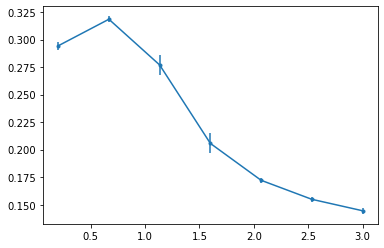

In [22]:
plt.errorbar(alphas,errgs_mean,errgs_std,marker=".")